# Variational EM Algorithm Part

# Upload preprocessed dataset

In [1]:
import pickle

with open('df_train.pkl', 'rb') as file:
    df_train = pickle.load(file)

with open('df_test.pkl', 'rb') as file:
    df_test = pickle.load(file)


print(f"Shape of training set: {df_train.shape}")
print(f"Shape of testing set: {df_test.shape}")

Shape of training set: (1702, 3)
Shape of testing set: (425, 3)


In [2]:
import pandas as pd
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df.head()

,text,labels,clean_text
0,EU 'too slow' on economic reforms\n\nMost EU c...,business,"[eu, slow, economic, reform, eu, country, fail..."
1,BBC web search aids odd queries\n\nThe BBC's o...,tech,"[bbc, web, search, aid, odd, query, bbc, onlin..."
2,Serena becomes world number two\n\nSerena Will...,sport,"[serena, becomes, world, number, serena, willi..."
3,Boothroyd calls for Lords speaker\n\nBetty Boo...,politics,"[boothroyd, call, lord, speaker, betty, boothr..."
4,Fast lifts rise into record books\n\nTwo high-...,tech,"[fast, lift, rise, record, book, lift, world, ..."


In [3]:
train_clean_text = df_train['clean_text'].tolist()
test_clean_text = df_test['clean_text'].tolist()

In [4]:
from collections import Counter

def construct_corpus(clean_text):
    word_to_id = {}  # Store unique word-ID pairs
    current_id = 0
    for text in clean_text:
        for word in text:
            if word not in word_to_id:
                word_to_id[word] = current_id
                current_id += 1

    corpus = []
    for text in clean_text:
        word_counts = Counter(text)
        count_freq = [(word_to_id[word], freq) for word, freq in word_counts.items()]
        corpus.append(count_freq)

    return corpus, word_to_id

train_corpus, train_word_to_id = construct_corpus(train_clean_text)


print(f"Number of documents in training set: {len(train_corpus)}")
print(f"Number of unique words in training set: {len(train_word_to_id)}")


# construct the testing set corpus using the training vocabulary encoding index to make sure word indexes are consistent
def construct_corpus_with_training_vocab(clean_text, word_to_id):
    corpus = []
    for text in clean_text:
        word_counts = Counter(text)
        count_freq = [
            (word_to_id[word], freq) for word, freq in word_counts.items() if word in word_to_id
        ]
        corpus.append(count_freq)
    return corpus

test_corpus = construct_corpus_with_training_vocab(test_clean_text, train_word_to_id)
print(f"Number of documents in test set: {len(test_corpus)}")

Number of documents in training set: 1702
Number of unique words in training set: 21927
Number of documents in test set: 425


In [5]:
from scipy.special import psi, polygamma, gammaln
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Configure logging for Jupyter
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True  # Force reconfiguration of logging handlers
)

logging.info("Logging configured in Jupyter.")

2024-12-09 18:15:18,843 - INFO - Logging configured in Jupyter.


# Train variational EM for the basic model, converge criteria is 0.01 or 100 iterations.

## Sample to show the algorithm is correctly implemented
## Number of topics = 5

In [6]:
def init_lda(corpus, vocab, num_topics, random_state=42):
    np.random.seed(random_state)

    W = len(vocab) # number of total words
    K = num_topics  # number of topics
    N = np.array([len(doc) for doc in corpus]) # number of words in each document
    D = len(corpus) # number of documents

    print(f"W: {W}\nK: {K}\nN: {N[:10]}...\nD: {D}")

    alpha = np.random.gamma(shape=100, scale=0.01, size=K)
    beta = np.random.dirichlet(np.ones(W), K)
    print(f"α: dim {alpha.shape}\nβ: dim {beta.shape}")

    # initialize ϕ, γ
    ## ϕ: (M x max(N) x k) arrays with zero paddings on the right
    gamma = alpha + np.ones((D, K)) * N.reshape(-1, 1) / K
    phi = np.ones((D, max(N), K)) / K
    for m, N_d in enumerate(N):
        phi[m, N_d:, :] = 0  # zero padding for vectorized operations

    print(f"γ: dim {gamma.shape}\nϕ: dim ({len(phi)}, N_d, {phi[0].shape[1]})")
# Return initialized parameters

    return W, K, N, D, alpha, beta, gamma, phi

In [7]:
# initialize data
W, K, N, D, alpha, beta, gamma, phi = init_lda(train_corpus, train_word_to_id, num_topics=5)

W: 21927
K: 5
N: [103  96  63  75 117  79 146 202  87 139]...
D: 1702
α: dim (5,)
β: dim (5, 21927)
γ: dim (1702, 5)
ϕ: dim (1702, N_d, 5)


In [8]:
from multiprocessing import Pool
import numpy as np
from scipy.special import psi

def process_document_E_step(doc_tuple):
    d, doc, N_d, phi, gamma_d, alpha, beta, K = doc_tuple

    # optimize phi for document d
    for n, (word_id, freq) in enumerate(doc):
        for k in range(K):
            phi[d, n, k] = beta[k, word_id] * np.exp(psi(gamma_d[k]) - psi(np.sum(gamma_d)))
        # Normalize phi[d, n, :]
        phi[d, n, :] /= phi[d, n, :].sum()

    # Update gamma for document d
    gamma_d = alpha + np.sum(phi[d, :N_d, :], axis=0)
    return d, phi[d], gamma_d

def E_step_parallel(corpus, N, phi, gamma, alpha, beta, K):
    # Prepare data for parallel processing
    data = [(d, doc, N[d], phi, gamma[d], alpha, beta, K) for d, doc in enumerate(corpus)]

    # Process each document in parallel
    with Pool() as pool:
        results = pool.map(process_document_E_step, data)

    # Update phi and gamma from results
    for d, phi_d, gamma_d in results:
        phi[d] = phi_d
        gamma[d] = gamma_d

    return phi, gamma


In [9]:
def process_document_M_step(doc_tuple):
    d, doc, W, phi = doc_tuple
    beta_update = np.zeros((phi.shape[2], W))

    # Update beta for document d
    for n, (word_id, freq) in enumerate(doc):
        beta_update[:, word_id] += freq * phi[d, n, :]

    return beta_update

def M_step_parallel(corpus, phi, gamma, alpha, beta, D, W):
    # Update alpha using Newton-Raphson
    alpha = update_alpha(alpha, gamma, D)

    # Prepare data for parallel processing
    data = [(d, doc, W, phi) for d, doc in enumerate(corpus)]

    # Process each document in parallel for beta update
    with Pool() as pool:
        beta_updates = pool.map(process_document_M_step, data)

    # Aggregate beta updates
    for beta_update in beta_updates:
        beta += beta_update

    # Normalize beta
    beta /= beta.sum(axis=1).reshape(-1, 1)

    return alpha, beta

import warnings

def update_alpha(alpha, gamma, D, max_iter=10000, tol=1e-6):

    for _ in range(max_iter):
        # store old value
        alpha0 = alpha.copy()

        # g: gradient
        psi_sum = psi(gamma.sum(axis=1)).reshape(-1, 1)
        g = D * (psi(alpha.sum()) - psi(alpha)) + (psi(gamma) - psi_sum).sum(axis=0)

        # H = diag(h) + 1z1'
        z = D * polygamma(1, alpha.sum())  # z: Hessian constant component
        h = -D * polygamma(1, alpha)       # h: Hessian diagonal component
        c = (g / h).sum() / (1./z + (1./h).sum())

        # update alpha
        alpha -= (g - c) / h

        # check convergence
        if np.sqrt(np.mean((alpha - alpha0) ** 2)) < tol:
            break
    else:
        warnings.warn(f"max_iter={max_iter} reached: values might not be optimal.")

    return alpha


In [10]:
def dg(gamma, d, i):

    return psi(gamma[d, i]) - psi(np.sum(gamma[d, :]))


def dl(lam, i, w_n):

    return psi(lam[i, w_n]) - psi(np.sum(lam[i, :]))

def vlb(corpus, phi, gamma, alpha, beta, D, K):

    lb = 0 # Lower bound accumulator
    for d, doc in enumerate(corpus):
        lb += (
            gammaln(np.sum(alpha))
            - np.sum(gammaln(alpha))
            + np.sum([(alpha[i] - 1) * dg(gamma, d, i) for i in range(K)])
        )

        lb -= (
            gammaln(np.sum(gamma[d, :]))
            - np.sum(gammaln(gamma[d, :]))
            + np.sum([(gamma[d, i] - 1) * dg(gamma, d, i) for i in range(K)])
        )

        for n, (word_id, freq) in enumerate(doc):
            lb += freq * np.sum([phi[d][n, i] * dg(gamma, d, i) for i in range(K)])
            try:
              lb += freq * np.sum([phi[d][n, i] * np.log(beta[i, word_id]) for i in range(K)])
            except Warning as e:
              lb += freq * np.sum([phi[d][n, i] * np.log(beta[i, word_id]) for i in range(K)])

            lb -= freq * np.sum([phi[d][n, i] * np.log(phi[d][n, i]) for i in range(K)])

    return lb / D

In [11]:
from tqdm import tqdm
import warnings

def lda_variational_em(corpus, W, K, N, D, alpha, beta, gamma, phi, n_iters=1000, tol=0.1, display=True):
    lb = -np.inf
    variational_lb = []
    for epoch in tqdm(range(n_iters), desc="LDA Variational EM", ncols=100):
        # Store old value of the lower bound
        lb_old = lb

        # E-step: Optimize phi and gamma in parallel
        phi, gamma = E_step_parallel(corpus, N, phi, gamma, alpha, beta, K)

        # M-step: Update alpha and beta in parallel
        alpha, beta = M_step_parallel(corpus, phi, gamma, alpha, beta, D, W)

        # Check for anomalies
        if np.any(np.isnan(alpha)):
            print("NaN detected in alpha")
            break

        # Check convergence by computing the variational lower bound (vlb)
        lb = vlb(corpus, phi, gamma, alpha, beta, D, K)
        err = abs(lb - lb_old)
        variational_lb.append(lb)

        # Check for anomalies in the lower bound
        if np.isnan(lb):
            print("NaN detected in lower bound")
            break

        # Display progress if enabled
        if display:
            print(f"\n{epoch:04}:  variational_lb: {lb:.3f},  error: {err:.3f}")

        # Check convergence based on tolerance
        if err < tol:
            break
    else:
        warnings.warn("Maximum iterations reached: values might not be optimal.")

    return alpha, beta, phi, gamma, variational_lb


In [12]:
alpha, beta, phi, gamma, variational_lb = lda_variational_em(
    corpus=train_corpus,
    W=W,
    K=K,
    N=N,
    D=D,
    alpha=alpha,
    beta=beta,
    phi=phi,
    gamma=gamma,
    n_iters=100,
    tol=0.01,
    display=True
)

LDA Variational EM:   1%|▍                                        | 1/100 [01:01<1:41:12, 61.34s/it]


0000:  variational_lb: -1622.628,  error: inf


LDA Variational EM:   2%|▊                                        | 2/100 [01:51<1:29:43, 54.93s/it]


0001:  variational_lb: -1621.161,  error: 1.467


LDA Variational EM:   3%|█▏                                       | 3/100 [02:37<1:22:21, 50.94s/it]


0002:  variational_lb: -1620.771,  error: 0.390


LDA Variational EM:   4%|█▋                                       | 4/100 [03:24<1:18:35, 49.12s/it]


0003:  variational_lb: -1620.546,  error: 0.224


LDA Variational EM:   5%|██                                       | 5/100 [04:10<1:15:56, 47.96s/it]


0004:  variational_lb: -1620.399,  error: 0.148


LDA Variational EM:   6%|██▍                                      | 6/100 [04:57<1:14:44, 47.71s/it]


0005:  variational_lb: -1620.296,  error: 0.103


LDA Variational EM:   7%|██▊                                      | 7/100 [05:44<1:13:45, 47.59s/it]


0006:  variational_lb: -1620.220,  error: 0.076


LDA Variational EM:   8%|███▎                                     | 8/100 [06:29<1:11:36, 46.70s/it]


0007:  variational_lb: -1620.163,  error: 0.058


LDA Variational EM:   9%|███▋                                     | 9/100 [07:15<1:10:41, 46.61s/it]


0008:  variational_lb: -1620.117,  error: 0.046


LDA Variational EM:  10%|████                                    | 10/100 [08:02<1:09:52, 46.58s/it]


0009:  variational_lb: -1620.079,  error: 0.037


LDA Variational EM:  11%|████▍                                   | 11/100 [08:49<1:09:10, 46.63s/it]


0010:  variational_lb: -1620.048,  error: 0.031


LDA Variational EM:  12%|████▊                                   | 12/100 [09:35<1:08:05, 46.42s/it]


0011:  variational_lb: -1620.021,  error: 0.027


LDA Variational EM:  13%|█████▏                                  | 13/100 [10:21<1:07:06, 46.28s/it]


0012:  variational_lb: -1619.998,  error: 0.023


LDA Variational EM:  14%|█████▌                                  | 14/100 [11:13<1:09:03, 48.17s/it]


0013:  variational_lb: -1619.977,  error: 0.021


LDA Variational EM:  15%|██████                                  | 15/100 [12:02<1:08:20, 48.24s/it]


0014:  variational_lb: -1619.959,  error: 0.019


LDA Variational EM:  16%|██████▍                                 | 16/100 [12:48<1:06:56, 47.81s/it]


0015:  variational_lb: -1619.941,  error: 0.017


LDA Variational EM:  17%|██████▊                                 | 17/100 [13:36<1:05:50, 47.60s/it]


0016:  variational_lb: -1619.925,  error: 0.016


LDA Variational EM:  18%|███████▏                                | 18/100 [14:21<1:04:04, 46.88s/it]


0017:  variational_lb: -1619.910,  error: 0.015


LDA Variational EM:  19%|███████▌                                | 19/100 [15:07<1:03:04, 46.72s/it]


0018:  variational_lb: -1619.895,  error: 0.015


LDA Variational EM:  20%|████████                                | 20/100 [15:55<1:02:55, 47.19s/it]


0019:  variational_lb: -1619.881,  error: 0.014


LDA Variational EM:  21%|████████▍                               | 21/100 [16:41<1:01:21, 46.60s/it]


0020:  variational_lb: -1619.867,  error: 0.014


LDA Variational EM:  22%|████████▊                               | 22/100 [17:27<1:00:24, 46.47s/it]


0021:  variational_lb: -1619.853,  error: 0.014


LDA Variational EM:  23%|█████████▋                                | 23/100 [18:14<59:47, 46.58s/it]


0022:  variational_lb: -1619.839,  error: 0.014


LDA Variational EM:  24%|██████████                                | 24/100 [19:01<59:15, 46.78s/it]


0023:  variational_lb: -1619.824,  error: 0.015


LDA Variational EM:  25%|██████████▌                               | 25/100 [19:46<57:51, 46.29s/it]


0024:  variational_lb: -1619.809,  error: 0.015


LDA Variational EM:  26%|██████████▉                               | 26/100 [20:32<56:57, 46.18s/it]


0025:  variational_lb: -1619.794,  error: 0.016


LDA Variational EM:  27%|███████████▎                              | 27/100 [21:25<58:41, 48.24s/it]


0026:  variational_lb: -1619.777,  error: 0.017


LDA Variational EM:  28%|███████████▊                              | 28/100 [22:13<57:51, 48.22s/it]


0027:  variational_lb: -1619.759,  error: 0.018


LDA Variational EM:  29%|████████████▏                             | 29/100 [22:59<56:16, 47.56s/it]


0028:  variational_lb: -1619.740,  error: 0.019


LDA Variational EM:  30%|████████████▌                             | 30/100 [23:45<55:01, 47.17s/it]


0029:  variational_lb: -1619.719,  error: 0.021


LDA Variational EM:  31%|█████████████                             | 31/100 [24:31<53:36, 46.62s/it]


0030:  variational_lb: -1619.696,  error: 0.023


LDA Variational EM:  32%|█████████████▍                            | 32/100 [25:17<52:38, 46.45s/it]


0031:  variational_lb: -1619.671,  error: 0.026


LDA Variational EM:  33%|█████████████▊                            | 33/100 [26:04<52:05, 46.65s/it]


0032:  variational_lb: -1619.642,  error: 0.029


LDA Variational EM:  34%|██████████████▎                           | 34/100 [26:51<51:33, 46.87s/it]


0033:  variational_lb: -1619.609,  error: 0.033


LDA Variational EM:  35%|██████████████▋                           | 35/100 [27:39<50:57, 47.04s/it]


0034:  variational_lb: -1619.572,  error: 0.037


LDA Variational EM:  36%|███████████████                           | 36/100 [28:25<50:00, 46.89s/it]


0035:  variational_lb: -1619.529,  error: 0.043


LDA Variational EM:  37%|███████████████▌                          | 37/100 [29:11<49:01, 46.69s/it]


0036:  variational_lb: -1619.479,  error: 0.050


LDA Variational EM:  38%|███████████████▉                          | 38/100 [29:58<48:11, 46.64s/it]


0037:  variational_lb: -1619.419,  error: 0.059


LDA Variational EM:  39%|████████████████▍                         | 39/100 [30:45<47:39, 46.88s/it]


0038:  variational_lb: -1619.348,  error: 0.071


LDA Variational EM:  40%|████████████████▊                         | 40/100 [31:37<48:16, 48.27s/it]


0039:  variational_lb: -1619.262,  error: 0.086


LDA Variational EM:  41%|█████████████████▏                        | 41/100 [32:26<47:50, 48.64s/it]


0040:  variational_lb: -1619.155,  error: 0.107


LDA Variational EM:  42%|█████████████████▋                        | 42/100 [33:12<46:13, 47.81s/it]


0041:  variational_lb: -1619.020,  error: 0.135


LDA Variational EM:  43%|██████████████████                        | 43/100 [33:58<44:46, 47.14s/it]


0042:  variational_lb: -1618.845,  error: 0.174


LDA Variational EM:  44%|██████████████████▍                       | 44/100 [34:45<44:03, 47.20s/it]


0043:  variational_lb: -1618.614,  error: 0.231


LDA Variational EM:  45%|██████████████████▉                       | 45/100 [35:31<42:47, 46.69s/it]


0044:  variational_lb: -1618.300,  error: 0.315


LDA Variational EM:  46%|███████████████████▎                      | 46/100 [36:16<41:44, 46.38s/it]


0045:  variational_lb: -1617.859,  error: 0.441


LDA Variational EM:  47%|███████████████████▋                      | 47/100 [37:03<40:58, 46.39s/it]


0046:  variational_lb: -1617.225,  error: 0.634


LDA Variational EM:  48%|████████████████████▏                     | 48/100 [37:49<40:12, 46.40s/it]


0047:  variational_lb: -1616.292,  error: 0.933


LDA Variational EM:  49%|████████████████████▌                     | 49/100 [38:35<39:23, 46.35s/it]


0048:  variational_lb: -1614.904,  error: 1.388


LDA Variational EM:  50%|█████████████████████                     | 50/100 [39:23<38:57, 46.74s/it]


0049:  variational_lb: -1612.853,  error: 2.051


LDA Variational EM:  51%|█████████████████████▍                    | 51/100 [40:10<38:07, 46.69s/it]


0050:  variational_lb: -1609.910,  error: 2.942


LDA Variational EM:  52%|█████████████████████▊                    | 52/100 [40:56<37:17, 46.61s/it]


0051:  variational_lb: -1605.894,  error: 4.017


LDA Variational EM:  53%|██████████████████████▎                   | 53/100 [41:48<37:43, 48.16s/it]


0052:  variational_lb: -1600.743,  error: 5.150


LDA Variational EM:  54%|██████████████████████▋                   | 54/100 [42:37<37:04, 48.37s/it]


0053:  variational_lb: -1594.583,  error: 6.161


LDA Variational EM:  55%|███████████████████████                   | 55/100 [43:26<36:32, 48.73s/it]


0054:  variational_lb: -1587.726,  error: 6.856


LDA Variational EM:  56%|███████████████████████▌                  | 56/100 [44:11<34:55, 47.61s/it]


0055:  variational_lb: -1580.638,  error: 7.089


LDA Variational EM:  57%|███████████████████████▉                  | 57/100 [44:58<33:52, 47.28s/it]


0056:  variational_lb: -1573.796,  error: 6.842


LDA Variational EM:  58%|████████████████████████▎                 | 58/100 [45:46<33:14, 47.48s/it]


0057:  variational_lb: -1567.539,  error: 6.258


LDA Variational EM:  59%|████████████████████████▊                 | 59/100 [46:31<31:58, 46.80s/it]


0058:  variational_lb: -1561.998,  error: 5.541


LDA Variational EM:  60%|█████████████████████████▏                | 60/100 [47:16<30:56, 46.42s/it]


0059:  variational_lb: -1557.164,  error: 4.834


LDA Variational EM:  61%|█████████████████████████▌                | 61/100 [48:04<30:18, 46.63s/it]


0060:  variational_lb: -1552.986,  error: 4.177


LDA Variational EM:  62%|██████████████████████████                | 62/100 [48:49<29:12, 46.12s/it]


0061:  variational_lb: -1549.451,  error: 3.536


LDA Variational EM:  63%|██████████████████████████▍               | 63/100 [49:34<28:22, 46.02s/it]


0062:  variational_lb: -1546.513,  error: 2.938


LDA Variational EM:  64%|██████████████████████████▉               | 64/100 [50:20<27:36, 46.01s/it]


0063:  variational_lb: -1544.095,  error: 2.417


LDA Variational EM:  65%|███████████████████████████▎              | 65/100 [51:06<26:50, 46.00s/it]


0064:  variational_lb: -1542.107,  error: 1.988


LDA Variational EM:  66%|███████████████████████████▋              | 66/100 [51:57<26:55, 47.53s/it]


0065:  variational_lb: -1540.444,  error: 1.663


LDA Variational EM:  67%|████████████████████████████▏             | 67/100 [52:47<26:30, 48.20s/it]


0066:  variational_lb: -1539.024,  error: 1.420


LDA Variational EM:  68%|████████████████████████████▌             | 68/100 [53:33<25:22, 47.58s/it]


0067:  variational_lb: -1537.808,  error: 1.216


LDA Variational EM:  69%|████████████████████████████▉             | 69/100 [54:19<24:17, 47.01s/it]


0068:  variational_lb: -1536.768,  error: 1.040


LDA Variational EM:  70%|█████████████████████████████▍            | 70/100 [55:05<23:21, 46.71s/it]


0069:  variational_lb: -1535.861,  error: 0.906


LDA Variational EM:  71%|█████████████████████████████▊            | 71/100 [55:51<22:27, 46.47s/it]


0070:  variational_lb: -1535.055,  error: 0.807


LDA Variational EM:  72%|██████████████████████████████▏           | 72/100 [56:38<21:45, 46.61s/it]


0071:  variational_lb: -1534.328,  error: 0.727


LDA Variational EM:  73%|██████████████████████████████▋           | 73/100 [57:25<20:59, 46.66s/it]


0072:  variational_lb: -1533.674,  error: 0.654


LDA Variational EM:  74%|███████████████████████████████           | 74/100 [58:11<20:07, 46.44s/it]


0073:  variational_lb: -1533.090,  error: 0.584


LDA Variational EM:  75%|███████████████████████████████▌          | 75/100 [58:56<19:14, 46.20s/it]


0074:  variational_lb: -1532.565,  error: 0.525


LDA Variational EM:  76%|███████████████████████████████▉          | 76/100 [59:43<18:30, 46.27s/it]


0075:  variational_lb: -1532.087,  error: 0.478


LDA Variational EM:  77%|██████████████████████████████▊         | 77/100 [1:00:31<17:58, 46.88s/it]


0076:  variational_lb: -1531.650,  error: 0.438


LDA Variational EM:  78%|███████████████████████████████▏        | 78/100 [1:01:16<16:57, 46.26s/it]


0077:  variational_lb: -1531.252,  error: 0.397


LDA Variational EM:  79%|███████████████████████████████▌        | 79/100 [1:02:09<16:54, 48.29s/it]


0078:  variational_lb: -1530.891,  error: 0.361


LDA Variational EM:  80%|████████████████████████████████        | 80/100 [1:02:57<16:05, 48.28s/it]


0079:  variational_lb: -1530.559,  error: 0.332


LDA Variational EM:  81%|████████████████████████████████▍       | 81/100 [1:03:43<15:06, 47.72s/it]


0080:  variational_lb: -1530.252,  error: 0.307


LDA Variational EM:  82%|████████████████████████████████▊       | 82/100 [1:04:29<14:10, 47.22s/it]


0081:  variational_lb: -1529.969,  error: 0.283


LDA Variational EM:  83%|█████████████████████████████████▏      | 83/100 [1:05:14<13:11, 46.54s/it]


0082:  variational_lb: -1529.706,  error: 0.263


LDA Variational EM:  84%|█████████████████████████████████▌      | 84/100 [1:06:00<12:20, 46.27s/it]


0083:  variational_lb: -1529.460,  error: 0.247


LDA Variational EM:  85%|██████████████████████████████████      | 85/100 [1:06:47<11:37, 46.47s/it]


0084:  variational_lb: -1529.222,  error: 0.238


LDA Variational EM:  86%|██████████████████████████████████▍     | 86/100 [1:07:32<10:45, 46.10s/it]


0085:  variational_lb: -1528.993,  error: 0.228


LDA Variational EM:  87%|██████████████████████████████████▊     | 87/100 [1:08:18<09:56, 45.90s/it]


0086:  variational_lb: -1528.775,  error: 0.219


LDA Variational EM:  88%|███████████████████████████████████▏    | 88/100 [1:09:05<09:16, 46.38s/it]


0087:  variational_lb: -1528.569,  error: 0.206


LDA Variational EM:  89%|███████████████████████████████████▌    | 89/100 [1:09:50<08:24, 45.87s/it]


0088:  variational_lb: -1528.375,  error: 0.194


LDA Variational EM:  90%|████████████████████████████████████    | 90/100 [1:10:36<07:39, 45.95s/it]


0089:  variational_lb: -1528.192,  error: 0.182


LDA Variational EM:  91%|████████████████████████████████████▍   | 91/100 [1:11:22<06:54, 46.07s/it]


0090:  variational_lb: -1528.020,  error: 0.172


LDA Variational EM:  92%|████████████████████████████████████▊   | 92/100 [1:12:14<06:21, 47.63s/it]


0091:  variational_lb: -1527.859,  error: 0.162


LDA Variational EM:  93%|█████████████████████████████████████▏  | 93/100 [1:13:01<05:33, 47.69s/it]


0092:  variational_lb: -1527.703,  error: 0.156


LDA Variational EM:  94%|█████████████████████████████████████▌  | 94/100 [1:13:48<04:44, 47.37s/it]


0093:  variational_lb: -1527.553,  error: 0.149


LDA Variational EM:  95%|██████████████████████████████████████  | 95/100 [1:14:33<03:52, 46.59s/it]


0094:  variational_lb: -1527.415,  error: 0.139


LDA Variational EM:  96%|██████████████████████████████████████▍ | 96/100 [1:15:19<03:05, 46.31s/it]


0095:  variational_lb: -1527.286,  error: 0.129


LDA Variational EM:  97%|██████████████████████████████████████▊ | 97/100 [1:16:05<02:18, 46.25s/it]


0096:  variational_lb: -1527.166,  error: 0.120


LDA Variational EM:  98%|███████████████████████████████████████▏| 98/100 [1:16:50<01:31, 45.98s/it]


0097:  variational_lb: -1527.052,  error: 0.113


LDA Variational EM:  99%|███████████████████████████████████████▌| 99/100 [1:17:35<00:45, 45.76s/it]


0098:  variational_lb: -1526.945,  error: 0.107


LDA Variational EM: 100%|███████████████████████████████████████| 100/100 [1:18:21<00:00, 47.01s/it]


0099:  variational_lb: -1526.840,  error: 0.106



<ipython-input-11-978b34eafc5a>:43: UserWarning: Maximum iterations reached: values might not be optimal.
  warnings.warn("Maximum iterations reached: values might not be optimal.")


In [ ]:
import pickle

with open('alpha.pkl', 'wb') as f:
    pickle.dump(alpha, f)

with open('beta.pkl', 'wb') as f:
    pickle.dump(beta, f)

with open('phi.pkl', 'wb') as f:
    pickle.dump(phi, f)

with open('gamma.pkl', 'wb') as f:
    pickle.dump(gamma, f)

with open('variational_lb.pkl', 'wb') as f:
    pickle.dump(variational_lb, f)

In [ ]:
from google.colab import files

files.download('alpha.pkl')
files.download('beta.pkl')
files.download('phi.pkl')
files.download('gamma.pkl')
files.download('variational_lb.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# with open('alpha.pkl', 'rb') as file:
#     alpha = pickle.load(file)

# with open('beta.pkl', 'rb') as file:
#     beta = pickle.load(file)

# with open('phi.pkl', 'rb') as file:
#     phi = pickle.load(file)

# with open('gamma.pkl', 'rb') as file:
#     gamma = pickle.load(file)

# with open('variational_lb.pkl', 'rb') as file:
#     variational_lb = pickle.load(file)

# This part is used to retrieve the trained parameters from the 100 iterations and number of topic = 5 case
# In case the link is unstable, I downloaded the trained parameters

In [24]:
def display_top_words(beta, id_to_word, num_words=10):
    """
    Display the top words for each topic based on the beta matrix.

    Parameters:
    - beta: Topic-word distribution matrix (shape: num_topics x vocab_size)
    - id_to_word: Dictionary mapping word IDs to actual words
    - num_words: Number of top words to display per topic
    """
    num_topics = beta.shape[0]  # Number of topics

    # Iterate over each topic and display the top words
    for topic_idx in range(num_topics):
        # Get the top word IDs for the current topic
        top_word_ids = np.argsort(beta[topic_idx])[::-1][:num_words]  # Sort in descending order

        # Map word IDs to actual words
        top_words = [id_to_word[word_id] for word_id in top_word_ids]

        # Display the topic and its top words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")


In [29]:
train_id_to_word = {v: k for k, v in train_word_to_id.items()}
display_top_words(beta, train_id_to_word, num_words=10)

Topic 0: market, company, price, firm, growth, economy, share, sale, bank, rate
Topic 1: people, game, music, film, show, technology, tv, mobile, phone, user
Topic 2: game, win, england, player, world, time, play, second, best, back
Topic 3: people, company, court, case, law, right, time, make, many, want
Topic 4: labour, party, election, government, blair, minister, tory, film, brown, people


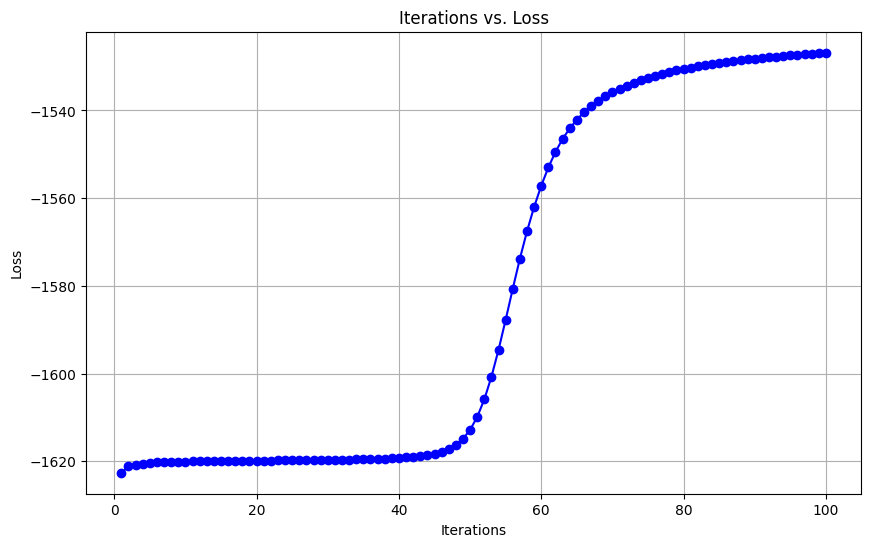

In [30]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
iterations = list(range(1, 101))  # Number of iterations (e.g., 100 iterations)
loss_values = variational_lb  # Replace with your loss values per iteration

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs. Loss")
plt.grid(True)
plt.show()

# Prediction and Perplexity

In [15]:
def lda_prediction(corpus, W, K, alpha, beta, max_iters=50, tol=1e-6):

    D = len(corpus)          # Number of documents in the test set
    N = [len(doc) for doc in corpus]  # Word counts per document
    max_N_d = max(N)         # Maximum number of words in a document

    # Initialize phi and gamma
    phi = np.zeros((D, max_N_d, K))
    gamma = np.zeros((D, K))

    # Loop through documents with progress tracking
    for d, doc in tqdm(enumerate(corpus), total=D, desc="Processing Documents", ncols=100):
        N_d = len(doc)  # Number of unique words in the document
        gamma_d = alpha + np.random.rand(K)  # Initialize gamma randomly

        for _ in range(max_iters):
            gamma_old = gamma_d.copy()

            # Update phi
            for n, (word_id, freq) in enumerate(doc):
                for k in range(K):
                    phi[d, n, k] = beta[k, word_id] * np.exp(psi(gamma_d[k]) - psi(np.sum(gamma_d)))
                phi[d, n, :] /= phi[d, n, :].sum()  # Normalize phi

            # Update gamma
            gamma_d = alpha + np.sum(phi[d, :N_d, :], axis=0)

            # Check convergence
            if np.sqrt(np.mean((gamma_d - gamma_old) ** 2)) < tol:
                break

        # Store results
        gamma[d] = gamma_d

    return phi, gamma


In [16]:
def calculate_perplexity(corpus, phi, gamma, beta, K):
    total_log_likelihood = 0
    total_words = sum(sum(freq for _, freq in doc) for doc in corpus)

    for d, doc in enumerate(corpus):
        doc_log_likelihood = 0
        for n, (word_id, freq) in enumerate(doc):
            # Compute the log-likelihood contribution for each word
            word_likelihood = np.dot(phi[d, n, :], beta[:, word_id])
            doc_log_likelihood += freq * np.log(word_likelihood + 1e-10)  # Add small epsilon for numerical stability

        total_log_likelihood += doc_log_likelihood

    # Compute perplexity
    perplexity = np.exp(-total_log_likelihood / total_words)
    return perplexity

In [17]:
phi_test, gamma_test = lda_prediction(
    corpus=test_corpus,
    W=len(train_word_to_id),
    K=5,
    alpha=alpha,
    beta=beta
)

Processing Documents: 100%|███████████████████████████████████████| 425/425 [02:08<00:00,  3.31it/s]


In [18]:
perplexity = calculate_perplexity(
    corpus=test_corpus,
    phi=phi_test,
    gamma=gamma_test,
    beta=beta,
    K=5
)
print(f"Perplexity: {perplexity:.4f}")


Perplexity: 1953.9353


# Experiments
## Varying number of topics:[2,5,10,20,50,100]
### Only train the case of 2, 5, 10 since the runtime is too long

In [ ]:
def run_lda_experiments(corpus_train, corpus_test, train_word_to_id, num_topics_list, n_iters=100, tol=0.1):
    perplexities = []

    for K in num_topics_list:
        print(f"Running LDA with {K} topics...")

        # Initialize parameters using init_lda
        W, K, N, D, alpha, beta, gamma, phi = init_lda(corpus_train, vocab=train_word_to_id, num_topics=K)

        # Train LDA
        alpha, beta, _, _, _ = lda_variational_em(
            corpus=corpus_train,
            W=W,
            K=K,
            N=N,
            D=D,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            phi=phi,
            n_iters=n_iters,
            tol=tol,
            display=False
        )

        # Predict for test set
        phi_test, gamma_test = lda_prediction(
            corpus=corpus_test,
            W=W,
            K=K,
            alpha=alpha,
            beta=beta
        )

        # Calculate perplexity
        perplexity = calculate_perplexity(
            corpus=corpus_test,
            phi=phi_test,
            gamma=gamma_test,
            beta=beta,
            K=K
        )
        perplexities.append(perplexity)
        print(f"Perplexity for {K} topics: {perplexity:.4f}")

    return perplexities


In [ ]:
# Parameters for experiments
num_topics_list = [2, 10, 20]
n_iters = 100
tol = 0.01

perplexity_5 = {5: perplexity} # from the previous sample to avoid recalculate

# Run experiments
perplexities = run_lda_experiments(
    corpus_train=train_corpus,
    corpus_test=test_corpus,
    train_word_to_id=train_word_to_id,
    num_topics_list=num_topics_list,
    n_iters=n_iters,
    tol=tol
)

combined_perplexities = perplexities.copy()

# Update it with the second dictionary
combined_perplexities.update(perplexity_5)
print(combined_perplexities)

Running LDA with 2 topics...
W: 21927
K: 2
N: [103  96  63  75 117  79 146 202  87 139]...
D: 1702
α: dim (2,)
β: dim (2, 21927)
γ: dim (1702, 2)
ϕ: dim (1702, N_d, 2)


LDA Variational EM: 100%|█████████████████████████████████████████| 100/100 [38:09<00:00, 22.90s/it]
<ipython-input-13-978b34eafc5a>:43: UserWarning: Maximum iterations reached: values might not be optimal.
  warnings.warn("Maximum iterations reached: values might not be optimal.")
Processing Documents: 100%|███████████████████████████████████████| 425/425 [00:44<00:00,  9.51it/s]


Perplexity for 2 topics: 3073.6158
Running LDA with 10 topics...
W: 21927
K: 10
N: [103  96  63  75 117  79 146 202  87 139]...
D: 1702
α: dim (10,)
β: dim (10, 21927)
γ: dim (1702, 10)
ϕ: dim (1702, N_d, 10)


Processing Documents: 100%|███████████████████████████████████████| 425/425 [03:58<00:00,  1.78it/s]


Perplexity for 10 topics: 1390.4193
Running LDA with 20 topics...
W: 21927
K: 20
N: [103  96  63  75 117  79 146 202  87 139]...
D: 1702
α: dim (20,)
β: dim (20, 21927)
γ: dim (1702, 20)
ϕ: dim (1702, N_d, 20)


LDA Variational EM:   0%|                                                   | 0/100 [00:00<?, ?it/s]

# Smoothed LDA

#### The code is finished but not trained

In [ ]:
def update_phi(D, N, k, phi, gamma, docs):
    for d in range(D):
        for n, (word_id, freq) in enumerate(docs[d]):
            for i in range(k):
                phi[d][n, i] = np.exp(dl(lam, i, word_id) + dg(gamma, d, i))

            # Normalize over topics
            phi[d][n, :] = phi[d][n, :] / np.sum(phi[d][n, :])
            phi[d][n, :] *= freq  # Scale by word frequency

    return phi

def update_gamma(D, phi, alpha):

    gamma = alpha + np.array([phi[d].sum(axis=0) for d in range(D)])

    return gamma


def update_lam(W, N, D, phi, lam, eta, docs):

    lam[:] = eta
    for d in range(D):  #, desc="MINORIZE lam"):
        for n, (word_id, freq) in enumerate(docs[d]):
            lam[:, word_id] += phi[d][n, :].T * freq

    return lam


def update_alpha(D, k, old_alpha, gamma, max_iter=1000, tol=0.1):

    alpha = old_alpha

    for _ in range(max_iter):
        alpha_old = alpha

        #  Calculate gradient
        g = D * (psi(np.sum(alpha)) - psi(alpha)) +\
            (psi(gamma) - psi(np.sum(gamma, axis=1)).reshape(-1, 1)).sum(axis=0)

        #  Calculate Hessian diagonal component
        h = -D * polygamma(1, alpha)

        #  Calculate Hessian constant component
        z = D * polygamma(1, np.sum(alpha))

        #  Calculate constant
        c = np.sum(g / h) / (z ** (-1.0) + np.sum(h ** (-1.0)))

        #  Update alpha
        alpha = alpha - (g - c) / h

        #  Check convergence
        if np.sqrt(np.mean(np.square(alpha - alpha_old))) < tol:
            break
    else:
        warnings.warn("_update_alpha(): max_iter reached.")

    return alpha


def update_eta(D, k, old_eta, lam, max_iter=1000, tol=0.1):

    eta = old_eta

    for _ in range(max_iter):
        eta_old = eta

        #  Calculate gradient
        g = k * (psi(np.sum(eta)) - psi(eta)) +\
            (psi(lam) - psi(np.sum(lam, axis=1)).reshape(-1, 1)).sum(axis=0)

        #  Calculate Hessian diagonal component
        h = -k * polygamma(1, eta)

        #  Calculate Hessian constant component
        z = k * polygamma(1, np.sum(eta))

        #  Calculate constant
        c = np.sum(g / h) / (z ** (-1.0) + np.sum(h ** (-1.0)))

        #  Update alpha
        eta = eta - (g - c) / h

        #  Check convergence
        if np.sqrt(np.mean(np.square(eta - eta_old))) < tol:
            break
    else:
        warnings.warn("_update_eta(): max_iter reached.")

    return eta


def E_step(D, N, k, eta, alpha, old_phi, old_gamma, old_lam, docs):

    phi = update_phi(D, N, k, old_phi, old_gamma, docs)
    gamma = update_gamma(D, phi, alpha)
    lam = update_lam(W, N, D, phi, old_lam, eta, docs)
    return phi, gamma, lam


def M_step(D, k, gamma, old_alpha, old_eta):

    alpha = update_alpha(D, k, old_alpha, gamma)
    eta = update_eta(D, k, old_eta, lam)
    return alpha, eta


def calc_vlb(D, N, k, phi, gamma, lam, alpha, eta, docs):

    # Initialize accumulators for terms in the VLB
    a0, a1, a2, a3_1, a3_2, a4, a5 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    for d in range(D):
        # Term a0: Contribution from Dirichlet prior eta
        a0 += (
            k * (gammaln(np.sum(eta)) - np.sum(gammaln(eta)))
            + np.sum([(eta[j] - 1) * dl(lam, i, j) for j in range(W) for i in range(k)])
        )

        # Term a1: Contribution from Dirichlet prior alpha
        a1 += (
            gammaln(np.sum(alpha))
            - np.sum(gammaln(alpha))
            + np.sum([(alpha[i] - 1) * dg(gamma, d, i) for i in range(k)])
        )

        # Term a4: Contribution from gamma for document d
        a4 += (
            gammaln(np.sum(gamma[d, :]))
            - np.sum(gammaln(gamma[d, :]))
            + np.sum([(gamma[d, i] - 1) * dg(gamma, d, i) for i in range(k)])
        )

        # Terms a3_2: Contribution from lambda
        for i in range(k):
            for j in range(W):
                a3_2 += (
                    gammaln(np.sum(lam[i, j]))
                    - np.sum(gammaln(lam[i, :]))
                    + np.sum((lam[i, j] - 1) * dl(lam, i, j))
                )

        # Terms a2, a3_1, a5: Contributions from phi and word-topic assignments
        for n, (w_n, freq) in enumerate(docs[d]):
            a2 += np.sum([phi[d][n, i] * dg(gamma, d, i) for i in range(k)])
            a3_1 += np.sum([phi[d][n, i] * dl(lam, i, w_n) for i in range(k)])
            a5 += np.sum([phi[d][n, i] * np.log(phi[d][n, i]) for i in range(k)])

    # Return the computed variational lower bound
    return a0 + a1 + a2 + a3_1 - a3_2 - a4 - a5



In [ ]:
def smoothLDA(D, N, k, eta, alpha, phi, gamma, lam, docs, max_iter=1000, tol=5, verbose=True):
    vlb = -np.inf

    for it in range(max_iter):
        old_vlb = vlb
        phi, gamma, lam = E_step(D, N, k, eta, alpha, phi, gamma, lam, docs)
        alpha, eta = M_step(D, k, gamma, alpha, eta)

        vlb = calc_vlb(D, N, k, phi, gamma, lam, alpha, eta, docs)
        err = vlb - old_vlb

        if verbose:
            print(f"Iteration {it+1}: {vlb: .3f} (delta: {err: .2f})")

        if err < tol:
            break
    else:
        warnings.warn("max_iter reached.")

#### Parameters

In [ ]:
docs = train_corpus
W = len(train_word_to_id)
k = K  # number of topics
N = np.array([sum(freq for _, freq in doc) for doc in train_corpus])
D = len(docs)

alpha = np.random.gamma(100, 0.01, k)
eta = np.ones(W)

# initialize variational parameters
# ϕ: (M x max(N) x k) arrays with zero paddings on the right
phi = [np.ones((len(doc), k)) / k for doc in docs]
gamma = alpha + (N / k).reshape(-1, 1)
lam = np.random.gamma(shape=100, scale=0.01, size=(k, W))